<a href="https://colab.research.google.com/github/aditipotnis/Multi-Layer-Perceptron/blob/main/COMP551_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Key Imports**

In [ ]:
from google.colab import drive
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

from typing import List
from tqdm import tqdm

from scipy.optimize import check_grad
from sklearn.model_selection import GridSearchCV, train_test_split

drive.mount('/content/drive')

Mounted at /content/drive


#Task 1: Load + Preprocess Data

Training set: (60000, 784), Labels: (60000,)
Test set: (10000, 784), Labels: (10000,)


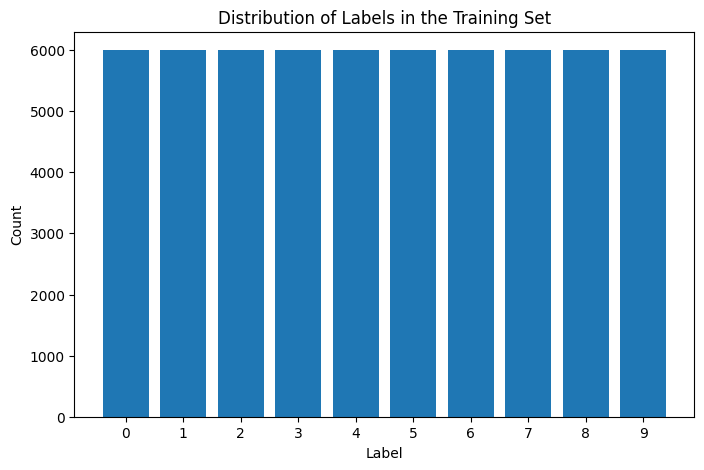

In [ ]:
#Load training set (60K images)
X_tr = np.load("drive/MyDrive/ML_A3/kmnist-train-imgs.npz")["arr_0"]
Y_tr = np.load("drive/MyDrive/ML_A3/kmnist-train-labels.npz")["arr_0"]

#Load test set (10K images)
X_te = np.load("drive/MyDrive/ML_A3/kmnist-test-imgs.npz")["arr_0"]
Y_te = np.load("drive/MyDrive/ML_A3/kmnist-test-labels.npz")["arr_0"]

#Flatten image matrices
X_tr = X_tr.reshape(X_tr.shape[0], -1)
X_te = X_te.reshape(X_te.shape[0], -1)

#Sanity Check
print(f"Training set: {X_tr.shape}, Labels: {Y_tr.shape}")
print(f"Test set: {X_te.shape}, Labels: {Y_te.shape}")

#one hot code labels
Y_tr = np.eye(10)[Y_tr]
Y_te = np.eye(10)[Y_te]

# Calculate the distribution of labels in the training set.
# Since Y_tr is one-hot encoded, summing along axis 0 gives the count for each label.
label_counts = np.sum(Y_tr, axis=0)

# Create a bar plot for the label distribution.
plt.figure(figsize=(8, 5))
plt.bar(range(10), label_counts, tick_label=range(10))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in the Training Set')
plt.show()


# Task 2

####Useful Functions

In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def evaluate_acc(y_true, y_pred):
    return np.mean(y_pred == np.argmax(y_true, axis=1))

def plot_history(history, title):

    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

**Define MLP class**

In [ ]:
class MLP:
    def __init__(self, M=[64, 64], activ=relu, hidden_layers=2, input_size=784, output_size=10):
      # Validate that length of M matches hidden_layers
      if len(M) != hidden_layers:
        raise ValueError("Length of M must match hidden_layers")
      self.activ = activ
      self.hidden_layers = hidden_layers
      self.input_size = input_size
      self.output_size = output_size
      # Create list of layer sizes: input, hidden, output
      self.layers = [input_size] + M + [output_size]

      # Initialize weights and biases
      self.weights_by_layer = []
      self.biases_by_layer = []
      for i in range(len(self.layers) - 1):
        weight = 0.01 * np.random.randn(self.layers[i+1], self.layers[i])
        bias = np.zeros((1, self.layers[i+1]))
        self.weights_by_layer.append(weight)
        self.biases_by_layer.append(bias)

    def forward(self, x):
      self.a = []  # list to store activations per layer
      self.z = []  # list to store linear combinations per layer
      a = x
      self.a.append(a)
      # Process hidden layers
      for i in range(len(self.weights_by_layer) - 1):
        z = np.dot(a, self.weights_by_layer[i].T) + self.biases_by_layer[i]
        self.z.append(z)
        a = self.activ(z)
        self.a.append(a)
      # Process final layer with softmax activation
      z = np.dot(a, self.weights_by_layer[-1].T) + self.biases_by_layer[-1]
      self.z.append(z)
      a = softmax(z)
      self.a.append(a)
      return a

    def backward(self, x, y):
      gradients = {}
      m = x.shape[0]  # number of examples in the batch
      # Compute delta for output layer
      a_final = self.a[-1]
      delta = (a_final - y) / m  # cross-entropy loss derivative

      # Gradients for final (output) layer
      dW = np.dot(delta.T, self.a[-2])
      db = np.sum(delta, axis=0, keepdims=True)
      gradients[f'dW{self.hidden_layers}'] = dW
      gradients[f'db{self.hidden_layers}'] = db

      # Backpropagate through hidden layers

      # Select derivative function based on activation function used
      if self.activ == relu:
          deriv = relu_derivative
      elif self.activ == leaky_relu:
          deriv = leaky_relu_derivative
      elif self.activ == sigmoid:
          deriv = sigmoid_derivative
      else:
          deriv = relu_derivative

      delta_prev = delta
      for i in range(self.hidden_layers - 1, -1, -1):
        # Propagate the error using the derivative of the activation function
        dz = np.dot(delta_prev, self.weights_by_layer[i+1]) * deriv(self.z[i])
        dW = np.dot(dz.T, self.a[i])
        db = np.sum(dz, axis=0, keepdims=True)
        gradients[f'dW{i}'] = dW
        gradients[f'db{i}'] = db
        delta_prev = dz

      return gradients

    def fit(self, x, y, learning_rate=0.01, epochs=10, batch_size=32, X_val=None, Y_val=None):
      n_samples = x.shape[0]
      history = {'train_loss': [], 'train_acc': []}
      if X_val is not None and Y_val is not None:
        history['val_acc'] = []

      for epoch in range(epochs):
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        x_shuffled = x[indices]
        y_shuffled = y[indices]
        epoch_loss = 0

        for i in range(0, n_samples, batch_size):
          x_batch = x_shuffled[i:i+batch_size]
          y_batch = y_shuffled[i:i+batch_size]
          output = self.forward(x_batch)
          epsilon = 1e-8
          loss = -np.sum(y_batch * np.log(output + epsilon)) / x_batch.shape[0]
          epoch_loss += loss
          gradients = self.backward(x_batch, y_batch)
          for j in range(len(self.weights_by_layer)):
            self.weights_by_layer[j] -= learning_rate * gradients[f'dW{j}']
            self.biases_by_layer[j] -= learning_rate * gradients[f'db{j}']

        avg_loss = epoch_loss / (n_samples // batch_size)
        history['train_loss'].append(avg_loss)
        train_acc = evaluate_acc(y, self.predict(x))
        history['train_acc'].append(train_acc)

        if X_val is not None and Y_val is not None:
          val_acc = evaluate_acc(Y_val, self.predict(X_val))
          history['val_acc'].append(val_acc)
          print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        else:
          print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}")

      return history



    def check_grad(self, x, y, epsilon=1e-5, tolerance=1e-4):
      numerical_gradients = {}
      # Compute analytical gradients
      self.forward(x)
      analytical_grads = self.backward(x, y)

      # Check gradients for each layer's weights and biases
      for l in range(len(self.weights_by_layer)):
        # Check weights gradients
        W = self.weights_by_layer[l]
        numerical_dW = np.zeros_like(W)
        for i in range(W.shape[0]):
          for j in range(W.shape[1]):
            original_value = W[i, j]
            # Perturb positively
            W[i, j] = original_value + epsilon
            plus_output = self.forward(x)
            loss_plus = -np.sum(y * np.log(plus_output + 1e-8)) / x.shape[0]
            # Perturb negatively
            W[i, j] = original_value - epsilon
            minus_output = self.forward(x)
            loss_minus = -np.sum(y * np.log(minus_output + 1e-8)) / x.shape[0]
            # Compute numerical gradient
            numerical_dW[i, j] = (loss_plus - loss_minus) / (2 * epsilon)
            # Restore original value
            W[i, j] = original_value
        numerical_gradients[f'dW{l}'] = numerical_dW

        # Check biases gradients
        b = self.biases_by_layer[l]
        numerical_db = np.zeros_like(b)
        for i in range(b.shape[0]):
          for j in range(b.shape[1]):
            original_value = b[i, j]
            # Perturb positively
            b[i, j] = original_value + epsilon
            plus_output = self.forward(x)
            loss_plus = -np.sum(y * np.log(plus_output + 1e-8)) / x.shape[0]
            # Perturb negatively
            b[i, j] = original_value - epsilon
            minus_output = self.forward(x)
            loss_minus = -np.sum(y * np.log(minus_output + 1e-8)) / x.shape[0]
            # Compute numerical gradient
            numerical_db[i, j] = (loss_plus - loss_minus) / (2 * epsilon)
            # Restore original value
            b[i, j] = original_value
        numerical_gradients[f'db{l}'] = numerical_db

      # Compare each analytical gradient with its numerical counterpart
      for key in analytical_grads:
        num_grad = numerical_gradients[key]
        ana_grad = analytical_grads[key]
        relative_error = np.linalg.norm(num_grad - ana_grad) / (np.linalg.norm(num_grad) + np.linalg.norm(ana_grad) + 1e-8)
        if relative_error < tolerance:
          print(f"{key} gradient check PASSED with relative error {relative_error}")
        else:
          print(f"{key} gradient check FAILED with relative error {relative_error}")

      return numerical_gradients

    def predict(self, x):
      probabilities = self.forward(x)
      return np.argmax(probabilities, axis=1)


    def fit_with_L2_reg(self, x, y, learning_rate=0.01, epochs=10, batch_size=32, lambda_reg=0.01):
      n = x.shape[0]
      for epoch in range(epochs):
        permutation = np.random.permutation(n)
        x_shuffled = x[permutation]
        y_shuffled = y[permutation]
        epoch_loss = 0
        for i in range(0, n, batch_size):
          x_batch = x_shuffled[i:i+batch_size]
          y_batch = y_shuffled[i:i+batch_size]

          y_pred = self.forward(x_batch)
          loss = -np.mean(y_batch * np.log(y_pred + 1e-8))

          for l in range(len(self.weights_by_layer)):
            loss += 0.5 * lambda_reg * np.sum(np.square(self.weights_by_layer[l]))
          epoch_loss += loss

          grads = self.backward(x_batch, y_batch)

          for l in range(len(self.weights_by_layer)):
            grads['dW' + str(l)] += lambda_reg * self.weights_by_layer[l]

          for l in range(len(self.weights_by_layer)):
            self.weights_by_layer[l] -= learning_rate * grads['dW' + str(l)]
            self.biases_by_layer[l] -= learning_rate * grads['db' + str(l)]

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/((n+batch_size-1)//batch_size):.4f}")

      return self

In [ ]:
np.random.seed(0)
model = MLP(M=[64, 64], activ=relu, hidden_layers=2, input_size=X_tr.shape[1], output_size=10)

# Perform gradient checking
model.check_grad(X_tr[:10], Y_tr[:10])


dW2 gradient check PASSED with relative error 5.103600357946487e-08
db2 gradient check PASSED with relative error 5.011909355233488e-08
dW1 gradient check PASSED with relative error 5.032621342769813e-08
db1 gradient check PASSED with relative error 5.156971758103544e-08
dW0 gradient check PASSED with relative error 5.106541977797012e-08
db0 gradient check PASSED with relative error 7.000137637650598e-08


{'dW0': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'db0': array([[ 1.66086256e-05,  8.42528269e-06,  3.26858540e-05,
         -1.47778678e-05,  2.17633467e-05,  3.73456377e-05,
          4.94042141e-05, -4.90883778e-05,  1.78631954e-04,
         -1.30686195e-04,  0.00000000e+00,  0.00000000e+00,
         -1.63257452e-04,  2.61361266e-04,  2.35797160e-05,
          5.56430457e-06, -1.06130682e-04, -6.58590738e-05,
          7.77971465e-05,  1.36804212e-04, -2.61196487e-04,
         -8.01083644e-06,  8.80626683e-06, -5.41756640e-05,
          3.02867909e-04, -1.12731513e-04,  2.70899303e-05,
         -3.90426580e-05, -8.19942780e-05,  2.86739099e-04,
          9.09999409e-05, -1.55520041e-05,  3.53077567e-06,
         -3.39646511e-04, -2.16814766e-04,  1.17567933e-04,
          1.74296

#Task 3: Experiments

In [ ]:
# Split training data into train and validation sets (80% train, 20% validation)
X_tr, X_val, Y_tr, Y_val = train_test_split(
    X_tr,
    Y_tr,
    test_size=0.2,
    random_state=42
)

# Compute statistics on the training set
train_mean = X_tr.mean(axis=0)
train_std = X_tr.std(axis=0)

# Standardize the datasets using training statistics
X_tr = (X_tr - train_mean) / train_std
X_val = (X_val - train_mean) / train_std
X_te = (X_te - train_mean) / train_std

### Experiment 1

Comparing models with:
1. No hidden layers
2. 1 hidden layer
3. hidden layer


Training no_hidden model with 32 hidden units:
Epoch 1/10, Loss: 0.7105, Train Acc: 0.8242, Val Acc: 0.8161
Epoch 2/10, Loss: 0.6029, Train Acc: 0.8280, Val Acc: 0.8171
Epoch 3/10, Loss: 0.5879, Train Acc: 0.8322, Val Acc: 0.8180
Epoch 4/10, Loss: 0.5797, Train Acc: 0.8354, Val Acc: 0.8202
Epoch 5/10, Loss: 0.5729, Train Acc: 0.8361, Val Acc: 0.8206
Epoch 6/10, Loss: 0.5680, Train Acc: 0.8368, Val Acc: 0.8187
Epoch 7/10, Loss: 0.5646, Train Acc: 0.8386, Val Acc: 0.8173
Epoch 8/10, Loss: 0.5614, Train Acc: 0.8398, Val Acc: 0.8196
Epoch 9/10, Loss: 0.5584, Train Acc: 0.8406, Val Acc: 0.8164
Epoch 10/10, Loss: 0.5558, Train Acc: 0.8393, Val Acc: 0.8168


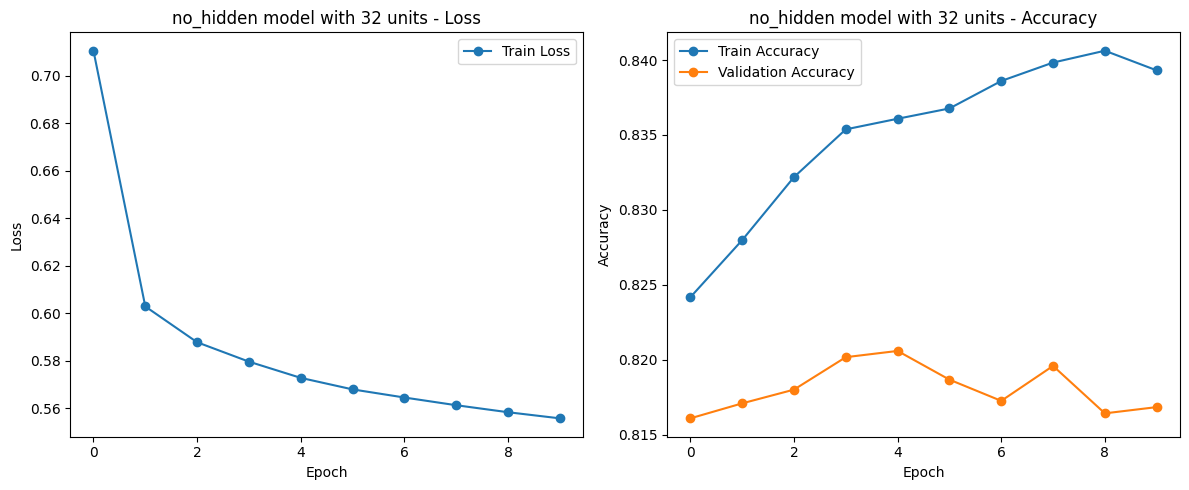

Validation accuracy for no_hidden model with 32 units: 0.8168

Training no_hidden model with 64 hidden units:
Epoch 1/10, Loss: 0.7109, Train Acc: 0.8231, Val Acc: 0.8152
Epoch 2/10, Loss: 0.6037, Train Acc: 0.8290, Val Acc: 0.8180
Epoch 3/10, Loss: 0.5878, Train Acc: 0.8338, Val Acc: 0.8189
Epoch 4/10, Loss: 0.5790, Train Acc: 0.8345, Val Acc: 0.8198
Epoch 5/10, Loss: 0.5730, Train Acc: 0.8364, Val Acc: 0.8183
Epoch 6/10, Loss: 0.5680, Train Acc: 0.8362, Val Acc: 0.8177
Epoch 7/10, Loss: 0.5643, Train Acc: 0.8385, Val Acc: 0.8177
Epoch 8/10, Loss: 0.5612, Train Acc: 0.8401, Val Acc: 0.8198
Epoch 9/10, Loss: 0.5584, Train Acc: 0.8391, Val Acc: 0.8157
Epoch 10/10, Loss: 0.5560, Train Acc: 0.8417, Val Acc: 0.8179


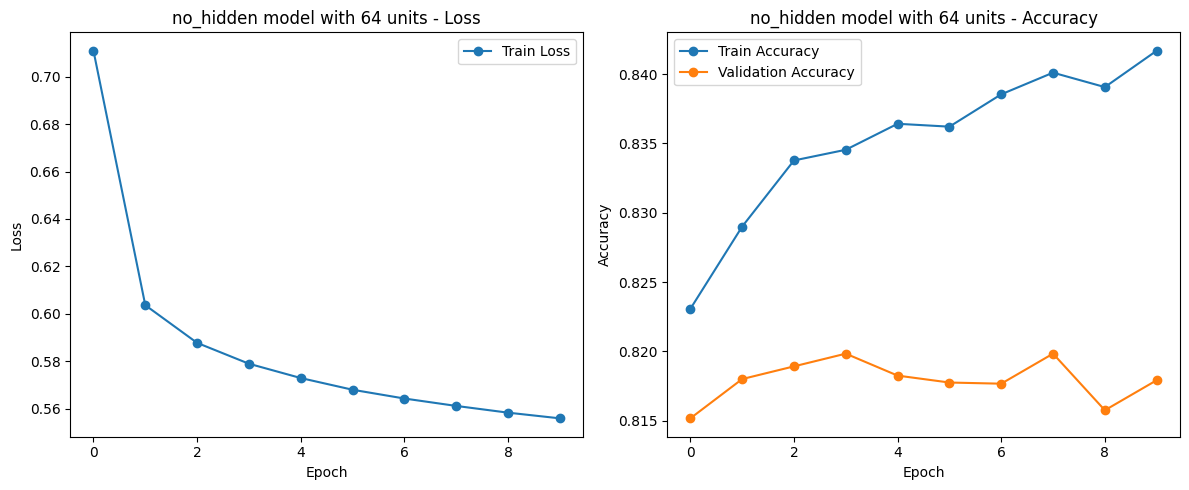

Validation accuracy for no_hidden model with 64 units: 0.8179

Training no_hidden model with 128 hidden units:
Epoch 1/10, Loss: 0.7086, Train Acc: 0.8232, Val Acc: 0.8150
Epoch 2/10, Loss: 0.6034, Train Acc: 0.8294, Val Acc: 0.8170
Epoch 3/10, Loss: 0.5881, Train Acc: 0.8327, Val Acc: 0.8203
Epoch 4/10, Loss: 0.5792, Train Acc: 0.8346, Val Acc: 0.8195
Epoch 5/10, Loss: 0.5724, Train Acc: 0.8371, Val Acc: 0.8203
Epoch 6/10, Loss: 0.5680, Train Acc: 0.8367, Val Acc: 0.8183
Epoch 7/10, Loss: 0.5642, Train Acc: 0.8385, Val Acc: 0.8187
Epoch 8/10, Loss: 0.5613, Train Acc: 0.8397, Val Acc: 0.8183
Epoch 9/10, Loss: 0.5580, Train Acc: 0.8411, Val Acc: 0.8175
Epoch 10/10, Loss: 0.5558, Train Acc: 0.8406, Val Acc: 0.8177


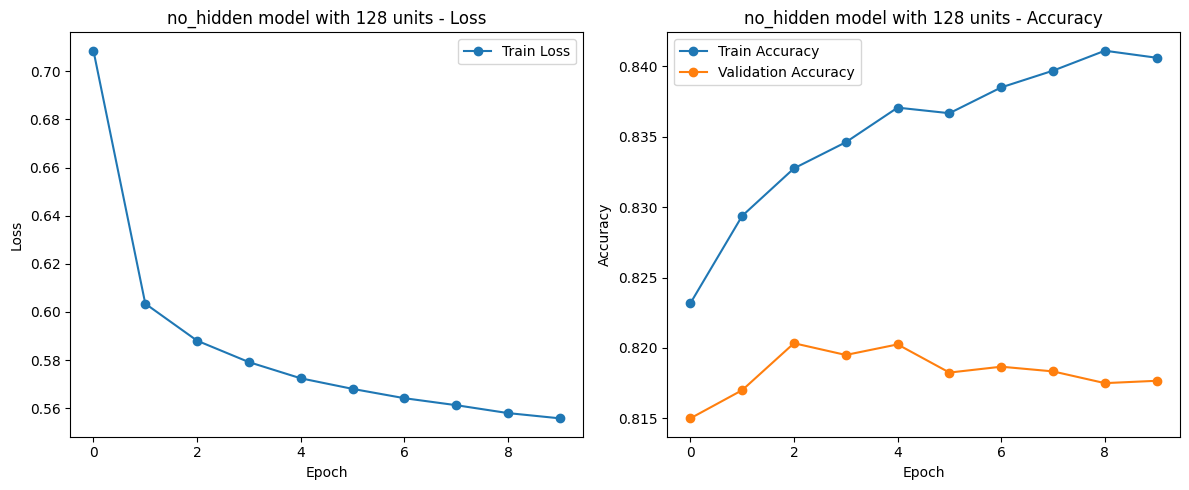

Validation accuracy for no_hidden model with 128 units: 0.8177

Training no_hidden model with 256 hidden units:
Epoch 1/10, Loss: 0.7102, Train Acc: 0.8219, Val Acc: 0.8129
Epoch 2/10, Loss: 0.6039, Train Acc: 0.8276, Val Acc: 0.8172
Epoch 3/10, Loss: 0.5878, Train Acc: 0.8323, Val Acc: 0.8179
Epoch 4/10, Loss: 0.5793, Train Acc: 0.8348, Val Acc: 0.8198
Epoch 5/10, Loss: 0.5728, Train Acc: 0.8359, Val Acc: 0.8195
Epoch 6/10, Loss: 0.5684, Train Acc: 0.8371, Val Acc: 0.8173
Epoch 7/10, Loss: 0.5647, Train Acc: 0.8394, Val Acc: 0.8179
Epoch 8/10, Loss: 0.5611, Train Acc: 0.8397, Val Acc: 0.8187
Epoch 9/10, Loss: 0.5580, Train Acc: 0.8392, Val Acc: 0.8163
Epoch 10/10, Loss: 0.5561, Train Acc: 0.8422, Val Acc: 0.8175


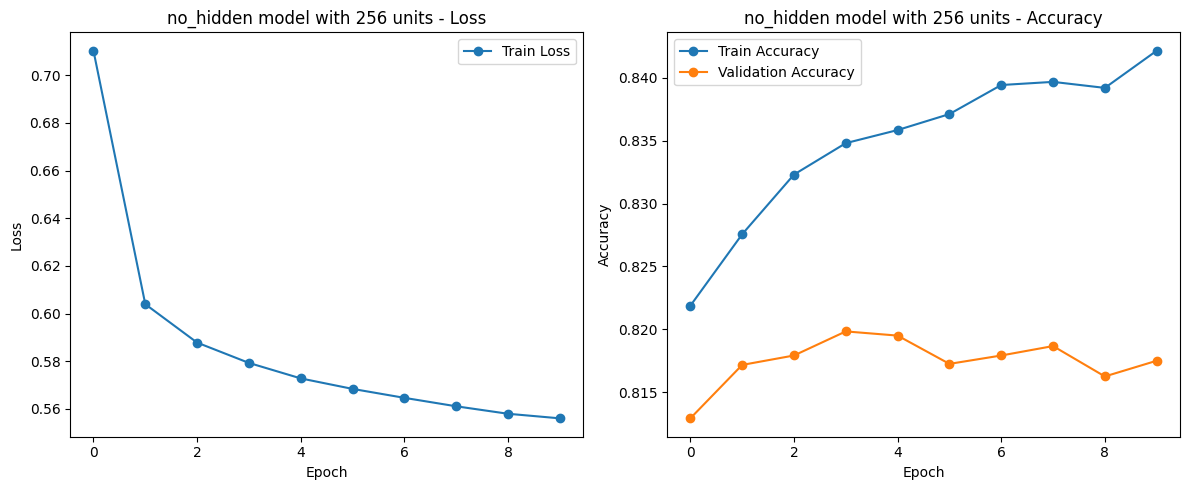

Validation accuracy for no_hidden model with 256 units: 0.8175
Best no_hidden model achieved validation accuracy: 0.8179

Training one_hidden model with 32 hidden units:
Epoch 1/10, Loss: 1.1751, Train Acc: 0.8326, Val Acc: 0.8303
Epoch 2/10, Loss: 0.4804, Train Acc: 0.8755, Val Acc: 0.8701
Epoch 3/10, Loss: 0.3865, Train Acc: 0.8955, Val Acc: 0.8886
Epoch 4/10, Loss: 0.3388, Train Acc: 0.9077, Val Acc: 0.8951
Epoch 5/10, Loss: 0.3080, Train Acc: 0.9156, Val Acc: 0.9025
Epoch 6/10, Loss: 0.2846, Train Acc: 0.9230, Val Acc: 0.9071
Epoch 7/10, Loss: 0.2667, Train Acc: 0.9282, Val Acc: 0.9097
Epoch 8/10, Loss: 0.2522, Train Acc: 0.9328, Val Acc: 0.9100
Epoch 9/10, Loss: 0.2394, Train Acc: 0.9355, Val Acc: 0.9135
Epoch 10/10, Loss: 0.2279, Train Acc: 0.9393, Val Acc: 0.9132


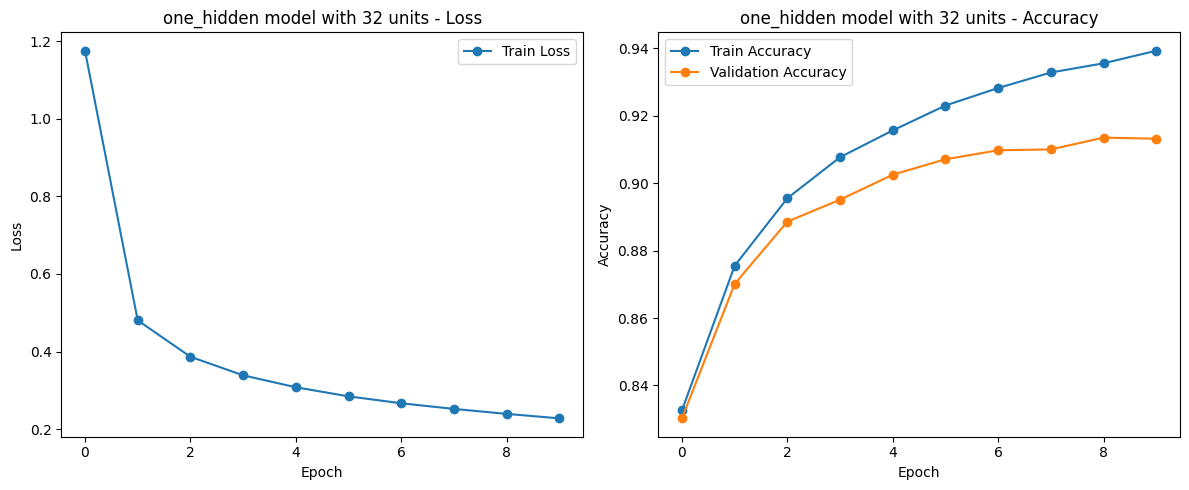

Validation accuracy for one_hidden model with 32 units: 0.9132

Training one_hidden model with 64 hidden units:
Epoch 1/10, Loss: 1.0760, Train Acc: 0.8411, Val Acc: 0.8383
Epoch 2/10, Loss: 0.4554, Train Acc: 0.8839, Val Acc: 0.8761
Epoch 3/10, Loss: 0.3592, Train Acc: 0.9041, Val Acc: 0.8957
Epoch 4/10, Loss: 0.3074, Train Acc: 0.9186, Val Acc: 0.9052
Epoch 5/10, Loss: 0.2722, Train Acc: 0.9275, Val Acc: 0.9112
Epoch 6/10, Loss: 0.2459, Train Acc: 0.9361, Val Acc: 0.9168
Epoch 7/10, Loss: 0.2241, Train Acc: 0.9415, Val Acc: 0.9196
Epoch 8/10, Loss: 0.2065, Train Acc: 0.9460, Val Acc: 0.9228
Epoch 9/10, Loss: 0.1912, Train Acc: 0.9507, Val Acc: 0.9253
Epoch 10/10, Loss: 0.1780, Train Acc: 0.9556, Val Acc: 0.9298


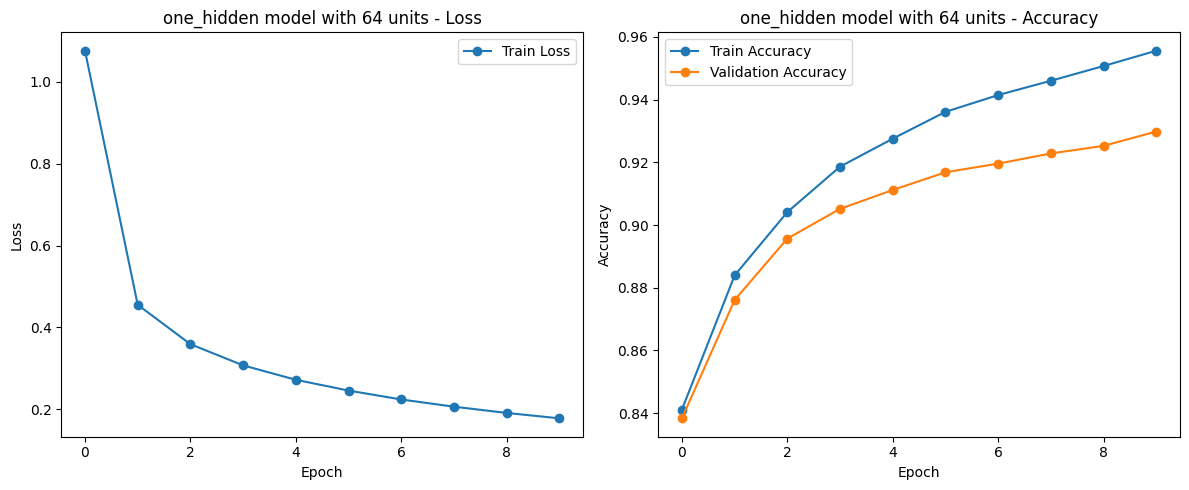

Validation accuracy for one_hidden model with 64 units: 0.9298

Training one_hidden model with 128 hidden units:
Epoch 1/10, Loss: 1.0159, Train Acc: 0.8429, Val Acc: 0.8416
Epoch 2/10, Loss: 0.4454, Train Acc: 0.8875, Val Acc: 0.8772
Epoch 3/10, Loss: 0.3477, Train Acc: 0.9091, Val Acc: 0.8959
Epoch 4/10, Loss: 0.2929, Train Acc: 0.9238, Val Acc: 0.9094
Epoch 5/10, Loss: 0.2551, Train Acc: 0.9334, Val Acc: 0.9173
Epoch 6/10, Loss: 0.2261, Train Acc: 0.9424, Val Acc: 0.9223
Epoch 7/10, Loss: 0.2030, Train Acc: 0.9487, Val Acc: 0.9278
Epoch 8/10, Loss: 0.1837, Train Acc: 0.9552, Val Acc: 0.9303
Epoch 9/10, Loss: 0.1670, Train Acc: 0.9603, Val Acc: 0.9332
Epoch 10/10, Loss: 0.1527, Train Acc: 0.9640, Val Acc: 0.9369


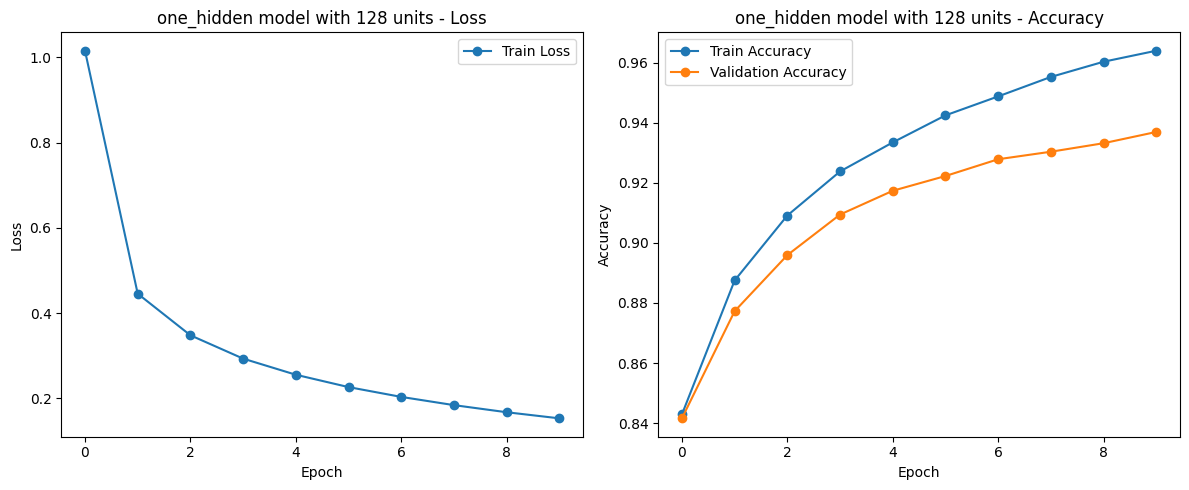

Validation accuracy for one_hidden model with 128 units: 0.9369

Training one_hidden model with 256 hidden units:
Epoch 1/10, Loss: 0.9439, Train Acc: 0.8548, Val Acc: 0.8544
Epoch 2/10, Loss: 0.4189, Train Acc: 0.8955, Val Acc: 0.8868
Epoch 3/10, Loss: 0.3272, Train Acc: 0.9144, Val Acc: 0.9040
Epoch 4/10, Loss: 0.2754, Train Acc: 0.9289, Val Acc: 0.9135
Epoch 5/10, Loss: 0.2391, Train Acc: 0.9399, Val Acc: 0.9229
Epoch 6/10, Loss: 0.2104, Train Acc: 0.9479, Val Acc: 0.9283
Epoch 7/10, Loss: 0.1875, Train Acc: 0.9540, Val Acc: 0.9327
Epoch 8/10, Loss: 0.1676, Train Acc: 0.9603, Val Acc: 0.9353
Epoch 9/10, Loss: 0.1507, Train Acc: 0.9657, Val Acc: 0.9383
Epoch 10/10, Loss: 0.1364, Train Acc: 0.9698, Val Acc: 0.9397


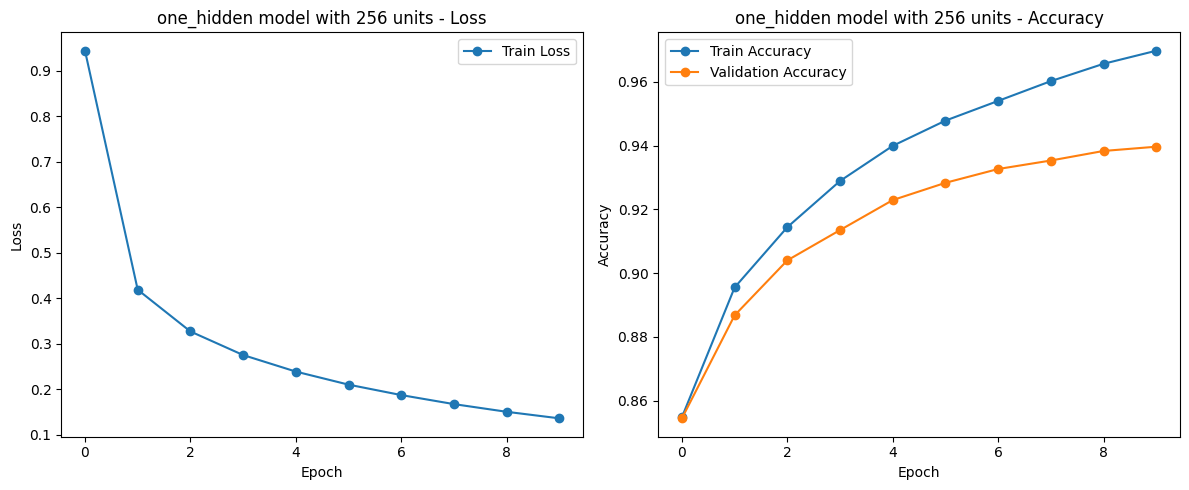

Validation accuracy for one_hidden model with 256 units: 0.9397
Best one_hidden model achieved validation accuracy: 0.9397

Training two_hidden model with 32 hidden units:
Epoch 1/10, Loss: 2.3017, Train Acc: 0.2242, Val Acc: 0.2157
Epoch 2/10, Loss: 2.0345, Train Acc: 0.2738, Val Acc: 0.2671
Epoch 3/10, Loss: 1.5576, Train Acc: 0.6509, Val Acc: 0.6560
Epoch 4/10, Loss: 0.9014, Train Acc: 0.7914, Val Acc: 0.7922
Epoch 5/10, Loss: 0.6052, Train Acc: 0.8570, Val Acc: 0.8438
Epoch 6/10, Loss: 0.4416, Train Acc: 0.8865, Val Acc: 0.8741
Epoch 7/10, Loss: 0.3646, Train Acc: 0.9022, Val Acc: 0.8881
Epoch 8/10, Loss: 0.3214, Train Acc: 0.9139, Val Acc: 0.8970
Epoch 9/10, Loss: 0.2904, Train Acc: 0.9220, Val Acc: 0.9026
Epoch 10/10, Loss: 0.2670, Train Acc: 0.9288, Val Acc: 0.9065


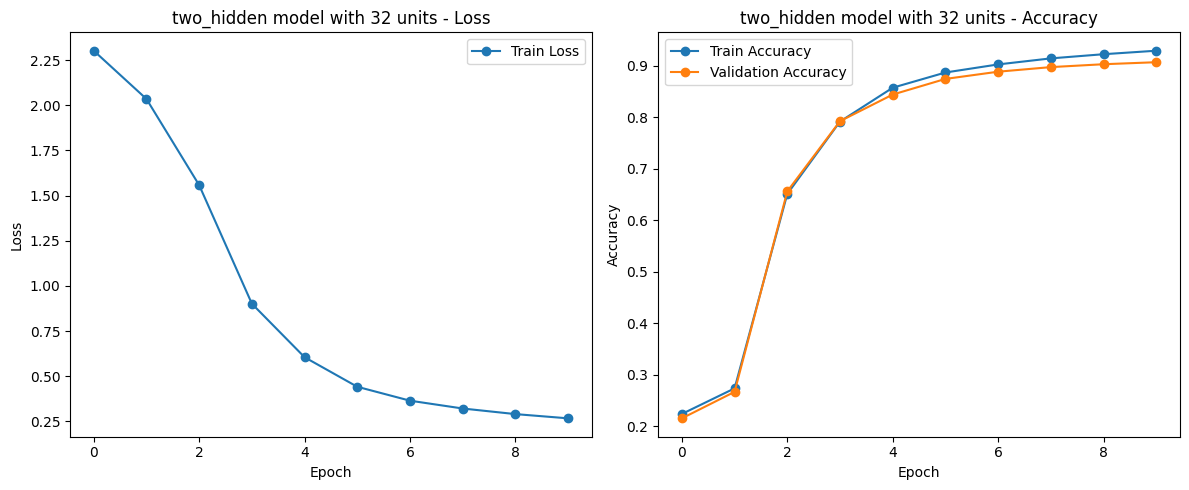

Validation accuracy for two_hidden model with 32 units: 0.9065

Training two_hidden model with 64 hidden units:
Epoch 1/10, Loss: 2.3008, Train Acc: 0.2484, Val Acc: 0.2397
Epoch 2/10, Loss: 1.8943, Train Acc: 0.5470, Val Acc: 0.5449
Epoch 3/10, Loss: 0.8372, Train Acc: 0.8157, Val Acc: 0.8117
Epoch 4/10, Loss: 0.4971, Train Acc: 0.8740, Val Acc: 0.8652
Epoch 5/10, Loss: 0.3820, Train Acc: 0.8982, Val Acc: 0.8873
Epoch 6/10, Loss: 0.3190, Train Acc: 0.9155, Val Acc: 0.8995
Epoch 7/10, Loss: 0.2766, Train Acc: 0.9288, Val Acc: 0.9090
Epoch 8/10, Loss: 0.2440, Train Acc: 0.9378, Val Acc: 0.9147
Epoch 9/10, Loss: 0.2173, Train Acc: 0.9465, Val Acc: 0.9196
Epoch 10/10, Loss: 0.1947, Train Acc: 0.9541, Val Acc: 0.9229


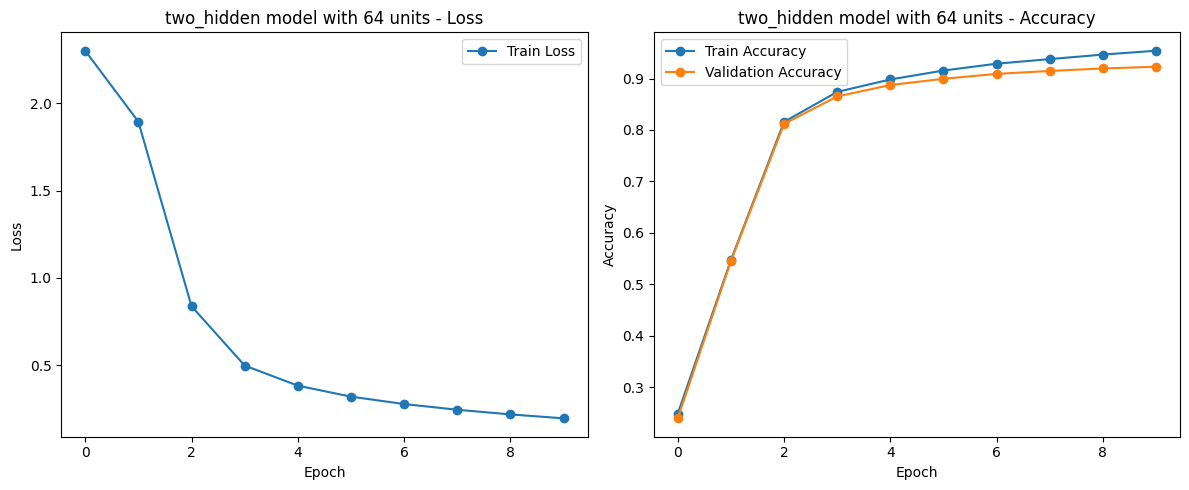

Validation accuracy for two_hidden model with 64 units: 0.9229

Training two_hidden model with 128 hidden units:
Epoch 1/10, Loss: 2.2321, Train Acc: 0.2426, Val Acc: 0.2357
Epoch 2/10, Loss: 1.1459, Train Acc: 0.7955, Val Acc: 0.7911
Epoch 3/10, Loss: 0.5221, Train Acc: 0.8725, Val Acc: 0.8666
Epoch 4/10, Loss: 0.3773, Train Acc: 0.9045, Val Acc: 0.8942
Epoch 5/10, Loss: 0.3015, Train Acc: 0.9249, Val Acc: 0.9097
Epoch 6/10, Loss: 0.2519, Train Acc: 0.9364, Val Acc: 0.9171
Epoch 7/10, Loss: 0.2156, Train Acc: 0.9471, Val Acc: 0.9238
Epoch 8/10, Loss: 0.1872, Train Acc: 0.9557, Val Acc: 0.9296
Epoch 9/10, Loss: 0.1626, Train Acc: 0.9624, Val Acc: 0.9337
Epoch 10/10, Loss: 0.1420, Train Acc: 0.9690, Val Acc: 0.9358


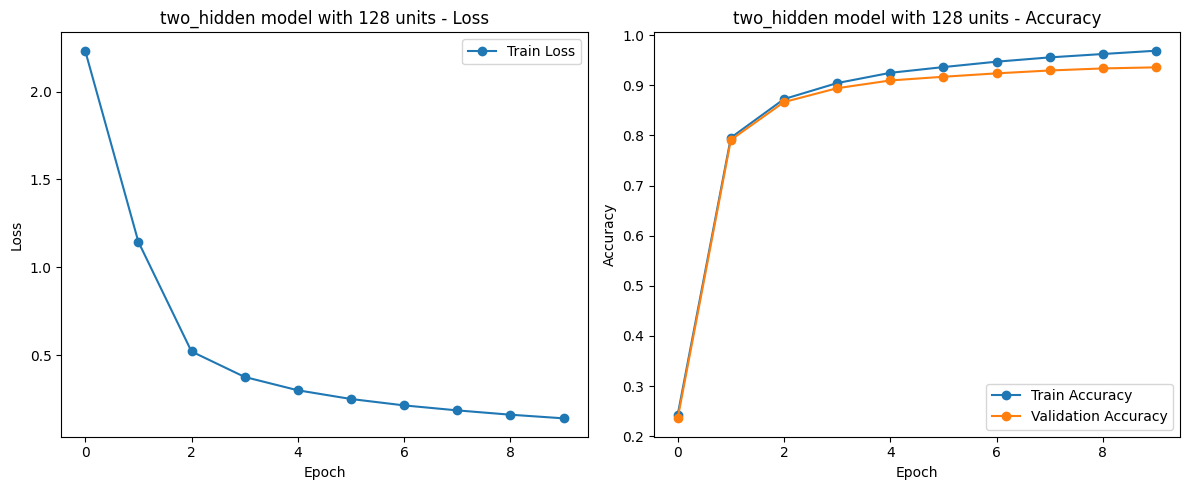

Validation accuracy for two_hidden model with 128 units: 0.9358

Training two_hidden model with 256 hidden units:
Epoch 1/10, Loss: 1.9792, Train Acc: 0.6471, Val Acc: 0.6480
Epoch 2/10, Loss: 0.7234, Train Acc: 0.8476, Val Acc: 0.8439
Epoch 3/10, Loss: 0.4165, Train Acc: 0.8998, Val Acc: 0.8916
Epoch 4/10, Loss: 0.3129, Train Acc: 0.9208, Val Acc: 0.9079
Epoch 5/10, Loss: 0.2561, Train Acc: 0.9362, Val Acc: 0.9182
Epoch 6/10, Loss: 0.2148, Train Acc: 0.9489, Val Acc: 0.9277
Epoch 7/10, Loss: 0.1820, Train Acc: 0.9593, Val Acc: 0.9341
Epoch 8/10, Loss: 0.1546, Train Acc: 0.9657, Val Acc: 0.9365
Epoch 9/10, Loss: 0.1320, Train Acc: 0.9727, Val Acc: 0.9376
Epoch 10/10, Loss: 0.1126, Train Acc: 0.9774, Val Acc: 0.9413


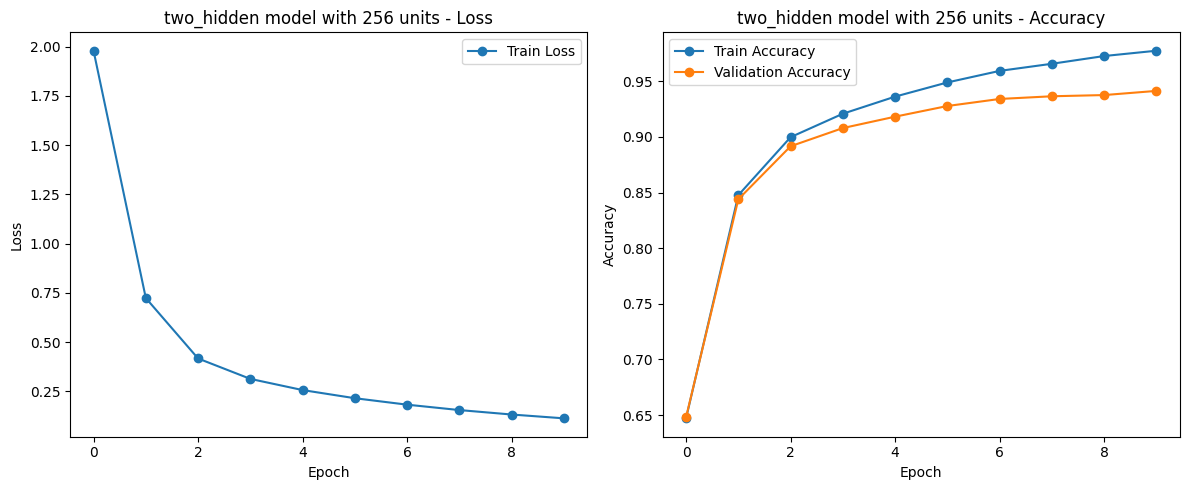

Validation accuracy for two_hidden model with 256 units: 0.9413
Best two_hidden model achieved validation accuracy: 0.9413

Final Test Set Evaluation:
Test accuracy for best no_hidden model: 0.6914
Test accuracy for best one_hidden model: 0.8699
Test accuracy for best two_hidden model: 0.8723


In [ ]:
# Experiment 1 : Model comparison
hidden_unit_options = [32, 64, 128, 256]
architecture_types = ["no_hidden", "one_hidden", "two_hidden"]

best_models = {}
best_val_accs = {}

for arch in architecture_types:
    best_val_acc = 0
    best_model = None
    for h in hidden_unit_options:
        if arch == "no_hidden":
            model = MLP(M=[], activ=relu, hidden_layers=0, input_size=784, output_size=10)
        elif arch == "one_hidden":
            model = MLP(M=[h], activ=relu, hidden_layers=1, input_size=784, output_size=10)
        elif arch == "two_hidden":
            model = MLP(M=[h, h], activ=relu, hidden_layers=2, input_size=784, output_size=10)

        print(f"\nTraining {arch} model with {h} hidden units:")
        # Capture the training history (loss and accuracy)
        history = model.fit(X_tr, Y_tr, learning_rate=0.01, epochs=10, batch_size=32,
                            X_val=X_val, Y_val=Y_val)

        # Plot training loss and accuracy
        plt.figure(figsize=(12, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], marker='o', label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"{arch} model with {h} units - Loss")
        plt.legend()

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], marker='o', label='Train Accuracy')
        if 'val_acc' in history:
            plt.plot(history['val_acc'], marker='o', label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f"{arch} model with {h} units - Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Evaluate on validation set
        val_pred = model.predict(X_val)
        val_acc = evaluate_acc(Y_val, val_pred)
        print(f"Validation accuracy for {arch} model with {h} units: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
    best_models[arch] = best_model
    best_val_accs[arch] = best_val_acc
    print(f"Best {arch} model achieved validation accuracy: {best_val_acc:.4f}")

# Experiment 1 : Output on Test Set
print("\nFinal Test Set Evaluation:")
for arch in architecture_types:
    best_model = best_models[arch]
    test_pred = best_model.predict(X_te)
    test_acc = evaluate_acc(Y_te, test_pred)
    print(f"Test accuracy for best {arch} model: {test_acc:.4f}")


##Experiment 2

the last model above, i.e., the one with 2 hidden layers, and create two different
copies of it in which the activation functions are now sigmoid and Leaky-ReLU. After training these two models compare their test accuracies with model having ReLU activations.


In [ ]:

print("\nTraining model with sigmoid activation (0 Hidden Layers):")
sig_model = MLP(M=[], activ=sigmoid, hidden_layers=0, input_size=784, output_size=10)
sig_model.fit(X_tr, Y_tr, learning_rate=0.01, epochs=10, batch_size=32)
val_acc = evaluate_acc(Y_val, sig_model.predict(X_val))
print(f"Validation accuracy: {val_acc:.4f}")

test_pred = sig_model.predict(X_te)
test_acc = evaluate_acc(Y_te, test_pred)
print(f"Test accuracy : {test_acc:.4f}")

print("\nTraining model with leaky_relu activation (0 Hidden Layers):")
leaky_model = MLP(M=[], activ=leaky_relu, hidden_layers=0, input_size=784, output_size=10)
leaky_model.fit(X_tr, Y_tr, learning_rate=0.01, epochs=10, batch_size=32)
val_acc = evaluate_acc(Y_val, leaky_model.predict(X_val))
print(f"Validation accuracy: {val_acc:.4f}")

test_pred = leaky_model.predict(X_te)
test_acc = evaluate_acc(Y_te, test_pred)
print(f"Test accuracy : {test_acc:.4f}")


print("\nTraining model with sigmoid activation (2 layers):")
sig_model = MLP(M=[256, 256], activ=sigmoid, hidden_layers=2, input_size=784, output_size=10)
sig_model.fit(X_tr, Y_tr, learning_rate=0.01, epochs=10, batch_size=32)
val_acc = evaluate_acc(Y_val, sig_model.predict(X_val))
print(f"Validation accuracy: {val_acc:.4f}")
test_pred = sig_model.predict(X_te)
test_acc = evaluate_acc(Y_te, test_pred)
print(f"Test accuracy : {test_acc:.4f}")

print("\nTraining model with leaky_relu activation (2 layers):")
leaky_model = MLP(M=[256, 256], activ=leaky_relu, hidden_layers=2, input_size=784, output_size=10)
leaky_model.fit(X_tr, Y_tr, learning_rate=0.01, epochs=10, batch_size=32)
val_acc = evaluate_acc(Y_val, leaky_model.predict(X_val))
print(f"Validation accuracy: {val_acc:.4f}")
test_pred = leaky_model.predict(X_te)
test_acc = evaluate_acc(Y_te, test_pred)
print(f"Test accuracy : {test_acc:.4f}")



Training model with sigmoid activation (0 Hidden Layers):
Epoch 1/10, Loss: 0.7119, Train Acc: 0.8223
Epoch 2/10, Loss: 0.6037, Train Acc: 0.8297
Epoch 3/10, Loss: 0.5885, Train Acc: 0.8332
Epoch 4/10, Loss: 0.5791, Train Acc: 0.8344
Epoch 5/10, Loss: 0.5732, Train Acc: 0.8356
Epoch 6/10, Loss: 0.5690, Train Acc: 0.8372
Epoch 7/10, Loss: 0.5638, Train Acc: 0.8376
Epoch 8/10, Loss: 0.5615, Train Acc: 0.8389
Epoch 9/10, Loss: 0.5581, Train Acc: 0.8412
Epoch 10/10, Loss: 0.5554, Train Acc: 0.8398
Validation accuracy: 0.8161
Test accuracy : 0.6927

Training model with leaky_relu activation (0 Hidden Layers):
Epoch 1/10, Loss: 0.7102, Train Acc: 0.8221
Epoch 2/10, Loss: 0.6039, Train Acc: 0.8287
Epoch 3/10, Loss: 0.5881, Train Acc: 0.8330
Epoch 4/10, Loss: 0.5801, Train Acc: 0.8338
Epoch 5/10, Loss: 0.5735, Train Acc: 0.8366
Epoch 6/10, Loss: 0.5687, Train Acc: 0.8374
Epoch 7/10, Loss: 0.5642, Train Acc: 0.8382
Epoch 8/10, Loss: 0.5613, Train Acc: 0.8393
Epoch 9/10, Loss: 0.5583, Train Acc

# Experiment 3

## Training using L2 regularization


Training 2-hidden layer model with L2 regularization, λ = 0.0
Epoch 1/10, Loss: 0.1976
Epoch 2/10, Loss: 0.0732
Epoch 3/10, Loss: 0.0420
Epoch 4/10, Loss: 0.0316
Epoch 5/10, Loss: 0.0257
Epoch 6/10, Loss: 0.0216
Epoch 7/10, Loss: 0.0183
Epoch 8/10, Loss: 0.0156
Epoch 9/10, Loss: 0.0134
Epoch 10/10, Loss: 0.0115
Test accuracy with λ = 0.0: 0.8681

Training 2-hidden layer model with L2 regularization, λ = 0.001
Epoch 1/10, Loss: 0.2154
Epoch 2/10, Loss: 0.0967
Epoch 3/10, Loss: 0.0718
Epoch 4/10, Loss: 0.0651
Epoch 5/10, Loss: 0.0624
Epoch 6/10, Loss: 0.0611
Epoch 7/10, Loss: 0.0604
Epoch 8/10, Loss: 0.0601
Epoch 9/10, Loss: 0.0602
Epoch 10/10, Loss: 0.0606
Test accuracy with λ = 0.001: 0.8628

Training 2-hidden layer model with L2 regularization, λ = 0.01
Epoch 1/10, Loss: 0.3329
Epoch 2/10, Loss: 0.2617
Epoch 3/10, Loss: 0.2551
Epoch 4/10, Loss: 0.2561
Epoch 5/10, Loss: 0.2578
Epoch 6/10, Loss: 0.2589
Epoch 7/10, Loss: 0.2603
Epoch 8/10, Loss: 0.2619
Epoch 9/10, Loss: 0.2635
Epoch 10/

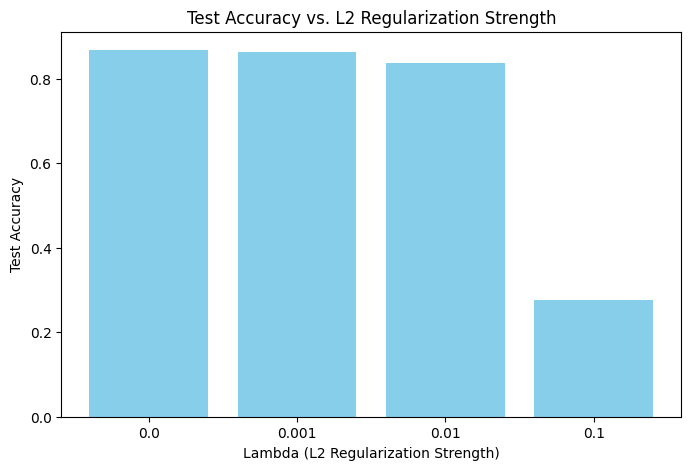

In [ ]:
lambda_values = [0.0, 0.001, 0.01, 0.1]
results = {}

for lambda_reg in lambda_values:
  print(f"\nTraining 2-hidden layer model with L2 regularization, λ = {lambda_reg}")
  model = MLP(M=[256, 256], activ=relu, hidden_layers=2, input_size=784, output_size=10)
  model.fit_with_L2_reg(X_tr, Y_tr, learning_rate=0.01, epochs=10, batch_size=32, lambda_reg=lambda_reg)
  test_acc = evaluate_acc(Y_te, model.predict(X_te))
  print(f"Test accuracy with λ = {lambda_reg}: {test_acc:.4f}")
  results[lambda_reg] = test_acc

# Plot the test accuracy versus the L2 regularization strength
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar([str(l) for l in lambda_values], [results[l] for l in lambda_values], color='skyblue')
plt.xlabel("Lambda (L2 Regularization Strength)")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. L2 Regularization Strength")
plt.show()

# Experiment 4

## Comparison with CNN

In [ ]:
# imports for CNN

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Dataset

#Load training set (60K images)
X_train = np.load("drive/MyDrive/ML_A3/kmnist-train-imgs.npz")["arr_0"]
Y_train = np.load("drive/MyDrive/ML_A3/kmnist-train-labels.npz")["arr_0"]

#Load test set (10K images)
X_test = np.load("drive/MyDrive/ML_A3/kmnist-test-imgs.npz")["arr_0"]
Y_test = np.load("drive/MyDrive/ML_A3/kmnist-test-labels.npz")["arr_0"]

# Reshape images to (28, 28, 1) instead of flattening them for the CNN
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize pixel values to [0,1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Sanity check of data shapes
print(f"Training set: {X_train.shape}, Labels: {Y_train.shape}")
print(f"Test set: {X_test.shape}, Labels: {Y_test.shape}")

# # One-hot encode labels
Y_train = np.eye(10)[Y_train]
Y_test = np.eye(10)[Y_test]

Training set: (60000, 28, 28, 1), Labels: (60000,)
Test set: (10000, 28, 28, 1), Labels: (10000,)


In [ ]:
# ConV net Model

def build_cnn_model(fc_units):
    model = Sequential([
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))

    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(fc_units, activation='relu'),
    Dense(fc_units, activation='relu'),
    Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Training model with 32 FC units...
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7199 - loss: 0.8631 - val_accuracy: 0.9528 - val_loss: 0.1608
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9610 - loss: 0.1331 - val_accuracy: 0.9696 - val_loss: 0.1027
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9787 - loss: 0.0738 - val_accuracy: 0.9736 - val_loss: 0.0911
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9846 - loss: 0.0522 - val_accuracy: 0.9778 - val_loss: 0.0789
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9901 - loss: 0.0342 - val_accuracy: 0.9791 - val_loss: 0.0742
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9930 - loss: 0.0239 - val_accuracy: 0.9806 - val_loss: 0.0694
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9932 - loss: 0.0208 - val_accuracy: 0.9750 - val_loss: 0.0918
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.99

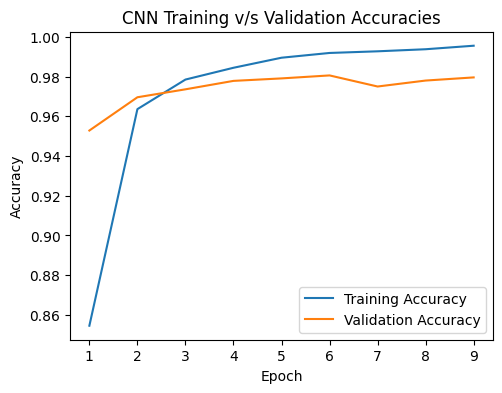

Validation accuracy for 32 FC units: 0.9806

Training model with 64 FC units...
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7645 - loss: 0.7453 - val_accuracy: 0.9587 - val_loss: 0.1414
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9677 - loss: 0.1039 - val_accuracy: 0.9732 - val_loss: 0.0931
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9834 - loss: 0.0578 - val_accuracy: 0.9778 - val_loss: 0.0711
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9884 - loss: 0.0358 - val_accuracy: 0.9814 - val_loss: 0.0675
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9922 - loss: 0.0252 - val_accuracy: 0.9827 - val_loss: 0.0671
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9946 - loss: 0.0164 - val_accuracy: 0.9831 - val_loss: 0.0646
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9959 - loss: 0.0131 - val_accuracy: 0.9808 - val_loss: 0.0744
Epoch 8/10
375/375 ━━━━━

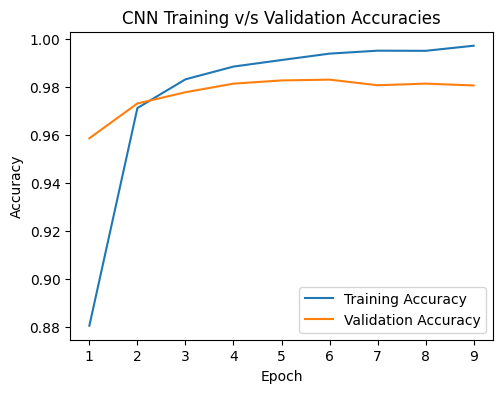

Validation accuracy for 64 FC units: 0.9831

Training model with 128 FC units...
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7723 - loss: 0.7014 - val_accuracy: 0.9643 - val_loss: 0.1192
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9724 - loss: 0.0899 - val_accuracy: 0.9793 - val_loss: 0.0678
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9869 - loss: 0.0425 - val_accuracy: 0.9803 - val_loss: 0.0655
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9911 - loss: 0.0266 - val_accuracy: 0.9839 - val_loss: 0.0578
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9951 - loss: 0.0154 - val_accuracy: 0.9840 - val_loss: 0.0587
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9960 - loss: 0.0131 - val_accuracy: 0.9837 - val_loss: 0.0644
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9960 - loss: 0.0132 - val_accuracy: 0.9796 - val_loss: 0.0761
Epoch 8/10
375/375 ━━━

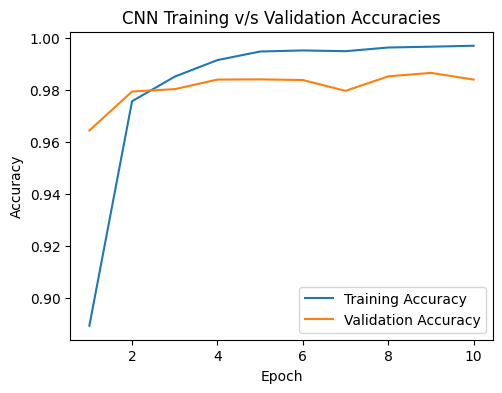

Validation accuracy for 128 FC units: 0.9865

Training model with 256 FC units...
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8015 - loss: 0.6242 - val_accuracy: 0.9658 - val_loss: 0.1115
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9748 - loss: 0.0810 - val_accuracy: 0.9797 - val_loss: 0.0656
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9882 - loss: 0.0384 - val_accuracy: 0.9764 - val_loss: 0.0776
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9925 - loss: 0.0239 - val_accuracy: 0.9835 - val_loss: 0.0634
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9951 - loss: 0.0161 - val_accuracy: 0.9852 - val_loss: 0.0569
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9952 - loss: 0.0149 - val_accuracy: 0.9836 - val_loss: 0.0633
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9969 - loss: 0.0105 - val_accuracy: 0.9849 - val_loss: 0.0662
Epoch 8/10
375/375 ━━━

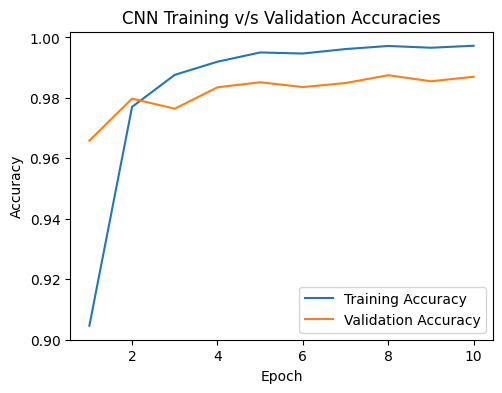

Validation accuracy for 256 FC units: 0.9875

Best number of FC units found: 256
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8170 - loss: 0.5651
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9801 - loss: 0.0653
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9893 - loss: 0.0330
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9933 - loss: 0.0211
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9949 - loss: 0.0148
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9966 - loss: 0.0108
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9969 - loss: 0.0103
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9972 - loss: 0.0093
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9976 - loss: 0.0071
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9975 - loss: 0.0085

Test accuracy of the best ConvNet: 0.9637


In [ ]:
# Experiment

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

fc_options = [32, 64, 128, 256]
results = {}
for units in fc_options:
    print(f"\nTraining model with {units} FC units...")
    model = build_cnn_model(units)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    history = model.fit(X_train, Y_train,
                        epochs=10,
                        batch_size=128,
                        validation_data=(X_valid, Y_valid),
                        callbacks=[early_stop],
                        verbose=1)
    plot_history(history=history, title="CNN Training v/s Validation Accuracies")
    best_val_acc = max(history.history['val_accuracy'])
    results[units] = best_val_acc
    print(f"Validation accuracy for {units} FC units: {best_val_acc:.4f}")

best_units = max(results, key=results.get)
print(f"\nBest number of FC units found: {best_units}")

X_full_train = np.concatenate([X_train, X_valid])
Y_full_train = np.concatenate([Y_train, Y_valid])
best_model = build_cnn_model(best_units)
best_model.fit(X_full_train, Y_full_train, epochs=10, batch_size=128, verbose=1)

test_loss, test_acc = best_model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTest accuracy of the best ConvNet: {test_acc:.4f}")

In [ ]:
!nvidia-smi

Wed Apr  2 17:47:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----